In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Read the data
langs = ['en','cs','de']
steps_epoch_mapping = {5: 500, 10: 1000, 15: 1500, 20: 2000, 25: 2500, 30: 3000, 35: 3500, 40: 4000}
epoch_steps_mapping = {v:k for k,v in steps_epoch_mapping.items()}
steps = steps_epoch_mapping.values()
kind = ['noisevignere3', 'noiseconstenigma']
evaldatasets = {lang:f'final_eval_dataset_{lang}.csv'  for lang in langs}
vignere_losses = {lang:f'{lang}_vignere_loss.csv'  for lang in langs}
enigmas = {lang:f'{lang}_enigma_loss.csv'  for lang in langs}
eval_col='eval_loss'

def vignerecol_name(lang, epoch):
    return f'{lang}_noisevignere3_{steps_epoch_mapping[epoch]}_cer'

def enigmacol_name(lang, epoch):
    return f'{lang}_noiseconstenigma_{steps_epoch_mapping[epoch]}_cer'
data_dfs: dict[str,pd.DataFrame] = {lang:pd.read_csv(evaldatasets[lang]) for lang in langs}

In [2]:
def proportion_of_chars(s, chars):
    return sum(c in chars for c in s) / len(s)
# additional static features
for data in data_dfs.values():
    data['e_pct'] = data['text'].apply(lambda x: proportion_of_chars(x, 'e'))
    data['spaces_pct'] = data['text'].apply(lambda x: proportion_of_chars(x, ' '))
    data['rare_letter_pct'] = data['text'].apply(lambda x: proportion_of_chars(x, 'xqjz'))
    data['text_length'] = data['text'].apply(len)


In [3]:
enigmaevolution_columns = {lang: [enigmacol_name(lang, epoch) for epoch in steps_epoch_mapping.keys()] for lang in langs}
vignereevolution_columns = {lang: [vignerecol_name(lang, epoch) for epoch in steps_epoch_mapping.keys()] for lang in langs}



In [4]:
from matplotlib import legend
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
FWER_P = 1.74e-05

def evolution_graph(lang, kind='vignere', save = None):
    legend_names = {
        'bigram_js_divergence': 'Char Bigram JSD',
        'depth_of_parse_tree': 'Dep. Tree Depth',
        'gpt2_perplexity': 'GPT-2 Perplexity',
        'gpt2_tokens_per_char': 'GPT-2 Tokenizer ',
        'named_entities': '# Named Entities',
        'pos_bigram_js_divergence': 'PoS Bigram JSD',
        'pos_js_divergence': 'PoS JSD',
        'unigram_js_divergence': 'Char JSD',
        'spaces_pct': 'Spaces %',
        'e_pct': 'E %',
        'rare_letter_pct': 'Rare Letter %',
        'text_length': 'Text Length'
    }
    properties = legend_names.keys()
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in range(len(properties))]
    
    data = data_dfs[lang]

    # renames 

    correlation_data = []
    p_values_data = []  # To store p-values
    epochs = list(steps_epoch_mapping.keys())

    # Calculate correlation and p-values for each feature across steps
    for prop in properties:
        feature_correlations = []
        feature_p_values = []
        for step in steps:
            if kind == 'vignere':
                ev_col = vignerecol_name(lang, epoch= epoch_steps_mapping[step])
            else:
                ev_col = enigmacol_name(lang, epoch= epoch_steps_mapping[step])
            # Calculate correlation and p-value between feature and evaluation result at this step
            correlation, p_value = pearsonr(data[prop], data[ev_col] )
            feature_correlations.append(abs(correlation))  # Storing magnitude of correlation
            feature_p_values.append(p_value)  # Storing p-value
        correlation_data.append(feature_correlations)
        p_values_data.append(feature_p_values)

    # Convert correlation and p-values data into DataFrames for easy plotting
    correlation_df = pd.DataFrame(correlation_data, index=properties, columns=epochs)
    p_values_df = pd.DataFrame(p_values_data, index=properties, columns=epochs)

    # Plotting with p-value annotations
    plt.figure(figsize=(6, 4.3))
    # # original
    # for idx,prop in enumerate(properties):
    #     plt.plot(epochs, correlation_df.loc[prop], marker='o',color=colors[idx], label=legend_names[prop])
    for idx, prop in enumerate(properties):
        series = correlation_df.loc[prop]
        epochs_filtered = [epoch for epoch, p_val in zip(epochs, p_values_df.loc[prop]) if p_val <= FWER_P]
        correlations_filtered = [corr for corr, p_val in zip(series, p_values_df.loc[prop]) if p_val <= FWER_P]
        nonsignificant_epochs = [epoch for epoch, p_val in zip(epochs, p_values_df.loc[prop]) if p_val > FWER_P]
        nonsignificant_correlations = [corr for corr, p_val in zip(series, p_values_df.loc[prop]) if p_val > FWER_P]

        # Plot lines connecting all points
        plt.plot(epochs, series, linestyle='-', color=colors[idx], label=legend_names[prop] if idx == 0 else "")

        # Plot significant points as filled markers
        plt.scatter(epochs_filtered, correlations_filtered, color=colors[idx], s=50, label=legend_names[prop] if epochs_filtered else "")

        # Plot nonsignificant points as empty markers
        plt.scatter(nonsignificant_epochs, nonsignificant_correlations, facecolors='none', edgecolors=colors[idx], s=50)

    ## nonsignif not filled
    # for idx, prop in enumerate(properties):
    #     for epoch, corr, p_val in zip(epochs, correlation_df.loc[prop], p_values_df.loc[prop]):
    #         if p_val > FWER_P:
    #             plt.plot(epoch, corr, marker='o', color=colors[idx], markersize=6, markerfacecolor='none',label=legend_names[prop] if epoch == epochs[0] else "")
    #         else:
    #             plt.plot(epoch, corr, marker='o', color=colors[idx], markersize=6, label=legend_names[prop] if epoch == epochs[0] else "")
    ## ???
        # for step, corr, p_val in zip(steps, correlation_df.loc[prop], p_values_df.loc[prop]):
        #     plt.annotate(f"{p_val:.2e}", (step, corr), textcoords="offset points", xytext=(0,10), ha='center')
    #start x axis at 0 and end at 40
    plt.xlim(3, 40.5)
    # logic for various graphs
    if kind == 'enigma' and (lang == 'en'):
        plt.ylim(0, .7)
        print('a')
    else:
        plt.ylim(0, .5)
        print('b')
    plt.xlabel('Training Epochs')
    plt.ylabel('Correlation with Evaluation CER')
    name = 'Vig' if kind == 'vignere' else 'Enigma'
    # lang_name = 'English' if lang == 'en' else 'Czech' if lang == 'cs' else 'German'
    lang_name= lang.upper()#capitalize

    plt.title(f'Property Correlation with CER Over Training Epochs in {name}_{lang_name} ')

    # Initially create the legend
    plt.legend()

    # Access the legend, then remove the first item
    leg = plt.gca().get_legend()
    handles, labels = leg.legendHandles, [text.get_text() for text in leg.get_texts()]
    handles.pop(0)
    labels.pop(0)


    plt.legend(handles,labels, borderpad=0.5,     # smaller border padding
          labelspacing=0.2,  # smaller label spacing
          handletextpad=0.2, # smaller handle-text padding
          handlelength=1,    # shorter handles
          loc='upper right',
          ncol=2)
    if save:
        plt.savefig(save)
        # print(p_values_df)
        # save p-values to csv
        save = save.replace('.pdf', '')
        p_values_df.to_csv(f'{save}_p_values.csv', float_format='%.2e')
    plt.show()
    # print corrmatrix

b


/tmp/ipykernel_1069651/2999549585.py:107: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles, labels = leg.legendHandles, [text.get_text() for text in leg.get_texts()]


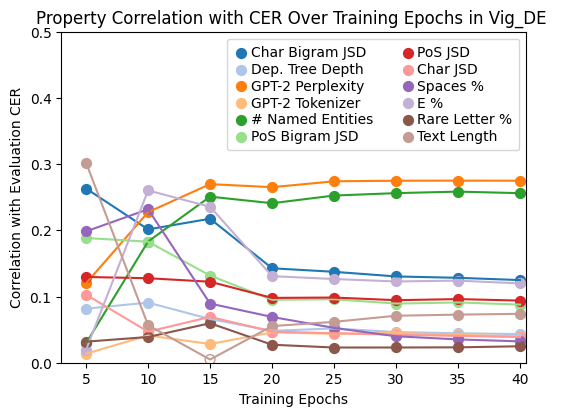

In [5]:
evolution_graph(lang='de', kind='vignere')

b


/tmp/ipykernel_1069651/2999549585.py:107: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles, labels = leg.legendHandles, [text.get_text() for text in leg.get_texts()]


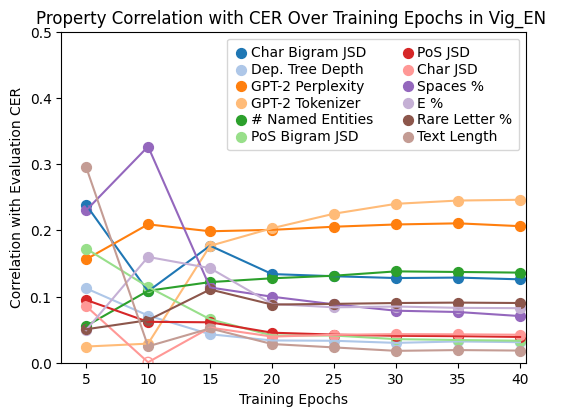

a


/tmp/ipykernel_1069651/2999549585.py:107: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles, labels = leg.legendHandles, [text.get_text() for text in leg.get_texts()]


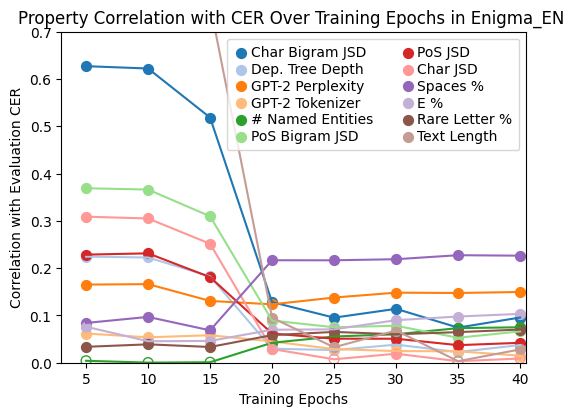

b


/tmp/ipykernel_1069651/2999549585.py:107: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles, labels = leg.legendHandles, [text.get_text() for text in leg.get_texts()]


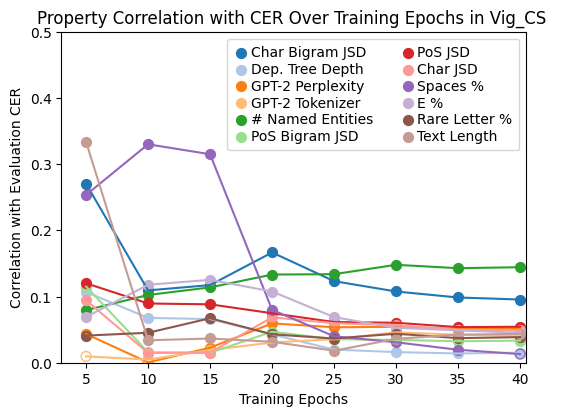

b


/tmp/ipykernel_1069651/2999549585.py:107: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles, labels = leg.legendHandles, [text.get_text() for text in leg.get_texts()]


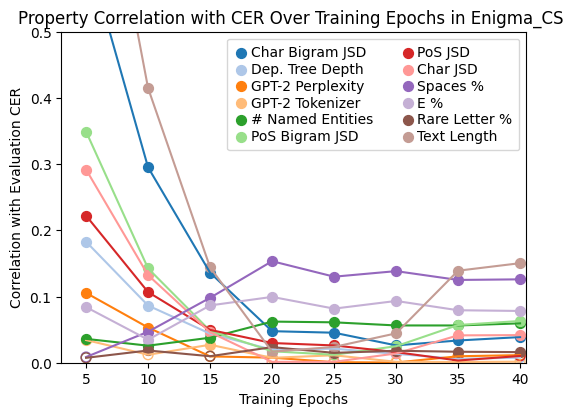

b


/tmp/ipykernel_1069651/2999549585.py:107: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles, labels = leg.legendHandles, [text.get_text() for text in leg.get_texts()]


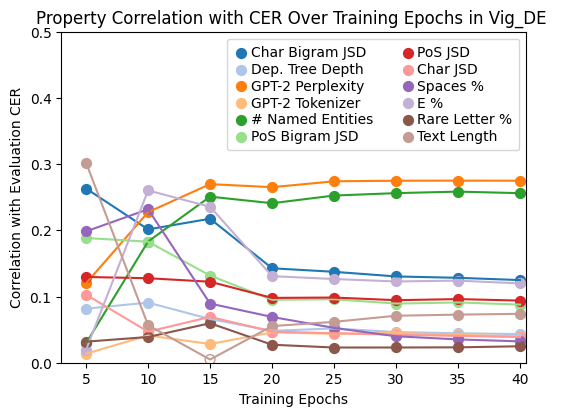

b


/tmp/ipykernel_1069651/2999549585.py:107: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles, labels = leg.legendHandles, [text.get_text() for text in leg.get_texts()]


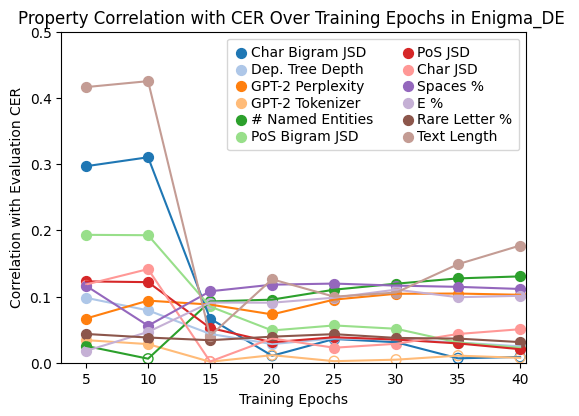

In [6]:
evolution_graph('en', kind='vignere', save='../img/en_vignere_evo_correlation.pdf')
evolution_graph('en', kind='enigma', save='../img/en_enigma_evo_correlation.pdf')
evolution_graph('cs', kind='vignere', save='../img/cs_vignere_evo_correlation.pdf')
evolution_graph('cs', kind='enigma', save='../img/cs_enigma_evo_correlation.pdf')
evolution_graph('de', kind='vignere', save='../img/de_vignere_evo_correlation.pdf')
evolution_graph('de', kind='enigma', save='../img/de_enigma_evo_correlation.pdf')